All the following configs are no longer maintained

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Define the rough loss function

`gaussian_kernel(dim, size, sigma)`  
`gaussian_blur_3d(frame, kernel_size, kernel_sigma)`  
`mse_loss(predi, label, kernel_size, kernel_sigma)`

We will use the MSE loss between the prediction and the label that both convolved with a samll Gaussian kernel. Thus, we first define our Gaussian kernel and use the kernel to perform Gaussian blur.

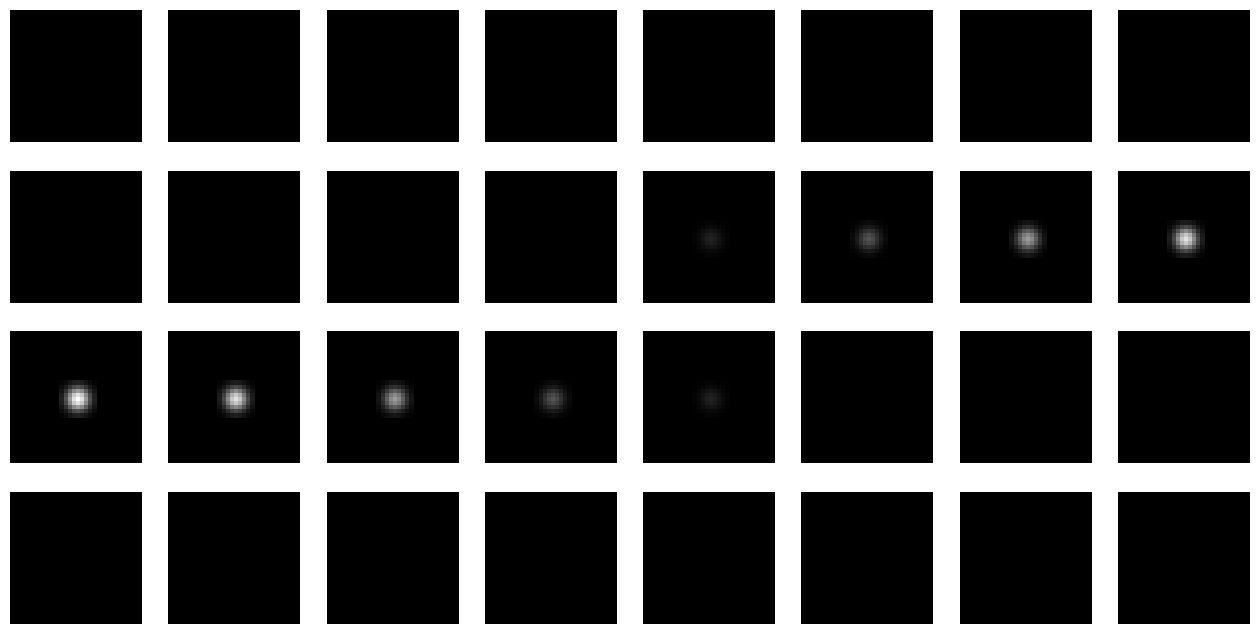

In [2]:
def gaussian_kernel(dim, kernel_size, kernel_sigma):
    # build 1D Gaussian kernel
    r = kernel_size // 2
    coord = torch.linspace(-r, r, kernel_size)
    kernel_1d  = torch.exp((-(coord / kernel_sigma)**2 / 2))
    kernel_1d /= kernel_1d.sum()  # Normalization

    # build nd Gaussian kernel using einsum
    equation = ','.join(f'{chr(97 + i)}' for i in range(dim))
    operands = [kernel_1d for _ in range(dim)]
    kernel_nd  = torch.einsum(equation, *operands)
    kernel_nd /= kernel_nd.sum()  # Normalization

    return kernel_nd  

def gaussian_blur_3d(frame, kernel_size, kernel_sigma):
    kernel = gaussian_kernel(frame.dim(), kernel_size, kernel_sigma)
    return F.conv3d(
        frame.reshape(1, 1, *frame.shape), 
        kernel.reshape(1, 1, *kernel.shape), 
        stride=1, padding=kernel_size//2).reshape(*frame.shape)

# test the gaussian_blur_3d function
frame = torch.zeros([32, 32, 32])
frame[16, 16, 16] = 1
frame = gaussian_blur_3d(frame, 9, 2)
frame /= torch.amax(frame)
# plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(32):
    row = i // 8
    col = i % 8
    axes[row, col].imshow(frame[i, :, :], cmap='gray', vmin=0, vmax=1)
    axes[row, col].axis('off')
plt.show()

Using this Gaussian blur help function, we define the loss function. We will using the **summation of elemental wise MSE** as out return value since the loss of our frame only depend on number of molecular instead of pixel number.

In [3]:
def mse_loss(predi, label, kernel_size, kernel_sigma):
    return F.mse_loss(
        gaussian_blur_3d(label, kernel_size, kernel_sigma), 
        gaussian_blur_3d(predi, kernel_size, kernel_sigma), 
        reduction="sum")

### Relation to position

`mse_loss_pad(predi, label, kernel_size, kernel_sigma)`

Set the frame dimension as 32 32 32 and the label's luminance as 0 except (16, 16, 16) as 1. Fix the kernel size at 7 and sigma at 1. We shife the predicting location of first dimension from 0 to 32. The plot below show the relation between the predict position and the loss. 

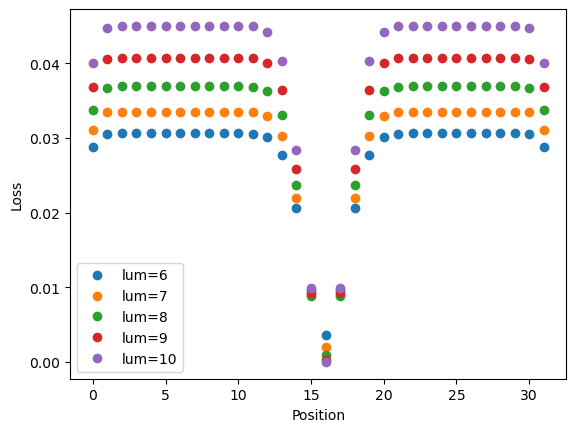

In [4]:
label = torch.zeros([32, 32, 32])
label[16, 16, 16] = 1

for lum in range(6, 11):
    loss_set = []
    for x in range(0, 32):
        predi = torch.zeros([32, 32, 32])
        predi[x, 16, 16] = lum / 10
        loss_set.append(mse_loss(predi, label, 7, 1))
    plt.plot( loss_set, 'o', 
        label="lum={}".format(lum))
plt.xlabel('Position')
plt.ylabel('Loss')
plt.legend()
plt.show()

Two problems appear here. First, the gradiant of loss is zero or very small when the position shift too much. However, this will not affect the optimization since we still have gradiant at the luminance. In fact, one of the reason we treat the locolization problem as regression problem instead of classification problem since the luminance can provide a gradiant to loss and the pixel that far away from the label will trend to have 0 for luminance. Next part provides an illustration to that. 

Second, there is a local minimum when the predict position too close to the boundary of the frame since half of the gaussian kernel is masked by the boundary of the frame. Thus, we need a tiny modification to the loss function where we pad the prediction frame `predi` and `label` by `kernel_size` before Gaussian blur. 

Some examples about the above problem show below where we use MSE loss between prediction and label that convolve with a Gaussian kernel with size 3 and sigma (1, 1). The branch size is 10, num of train and validation data is 5000 and 1250. After 24 epoch trainning and plot the prediction result of each epoch, we find that the predicted pixels tend to place at the boundary of the frame. Same result appear in the first frame generate by `DataLoader(SimDataset(Config(), 1),)` with NumPy random seed set at [0](https://github.com/tianrui-qi/DL-SMLFM/blob/main/assets/test_criterion/0.tif), [4](https://github.com/tianrui-qi/DL-SMLFM/blob/main/assets/test_criterion/4.tif), [5](https://github.com/tianrui-qi/DL-SMLFM/blob/main/assets/test_criterion/5.tif), and [6](https://github.com/tianrui-qi/DL-SMLFM/blob/main/assets/test_criterion/6.tif). In the saved tif, we stack the 3D outputs of the network from an epoch in z direction to form a 2D image and then combine all 2D images from each epoch to form a 3D tif that show the change of prediction during training. The input frames mark as gray, labels mark as red, and predictions mark as cyan. 

In [5]:
def mse_loss_pad(predi, label, kernel_size, kernel_sigma):
    pad_size = [kernel_size for _ in range(6)]
    return F.mse_loss(
        gaussian_blur_3d(F.pad(predi, pad_size), kernel_size, kernel_sigma), 
        gaussian_blur_3d(F.pad(label, pad_size), kernel_size, kernel_sigma), 
        reduction='none').sum()

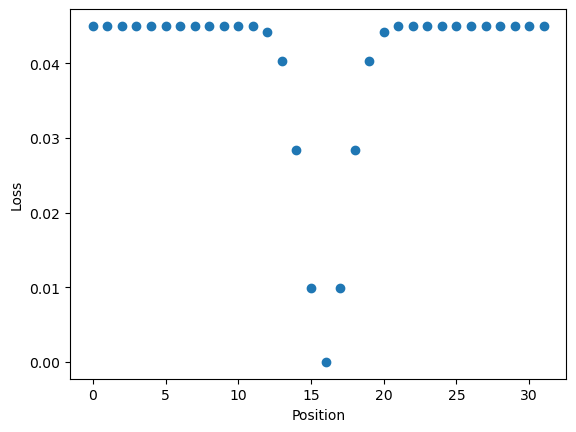

In [6]:
loss_set = []
for x in range(0, 32):
    predi = torch.zeros([32, 32, 32])
    predi[x, 16, 16] = 1
    loss_set.append(mse_loss_pad(predi, label, 7, 1))
plt.plot(loss_set, 'o')
plt.xlabel('Position')
plt.ylabel('Loss')
plt.show()

### Relation to luminance

Now, we shife the predict location from 0 pixel to 5 pixel; for each prediction, we then shift the luminance of the predict pixel from 0 to 1 with step size 0.1. The plot below show the relation between the luminance and the loss. 

As the predict position shift from the label, the luminance trend to be 0 in order to decrease the loss value. Thus, the position that shift from label too much will still have gradiant from luminance. 

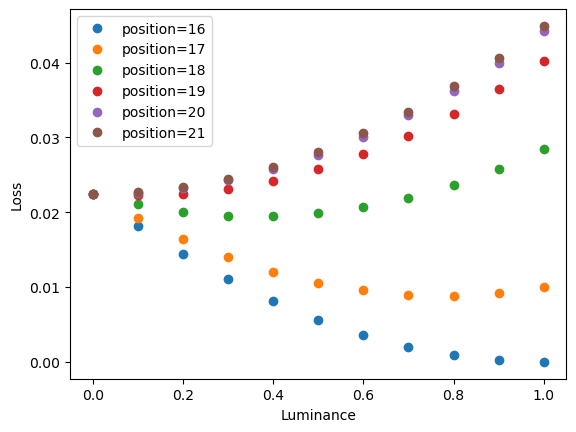

In [7]:
for position in range(16, 22, 1):
    loss_set = []
    for lum in range(0, 11):
        predi = torch.zeros([32, 32, 32])
        predi[position, 16, 16] = lum / 10
        loss_set.append(mse_loss(predi, label, 7, 1))
    plt.plot(
        torch.linspace(0, 10, 11)/10, loss_set, 'o', 
        label="position={}".format(position))
plt.xlabel('Luminance')
plt.ylabel('Loss')
plt.legend()
plt.show()

However, one problem shows above is that, when the predict position is close to the label, i.e., shift is 1, the minimum loss is not at luminance at 0 but around 0.8. This is because we use a convolved label when calculate the loss and there are luminance around the label if the kernel sigma is large. Below, we remain all parameters same except we set kernel sigma at 0.5, the situation has improved dramatically. 

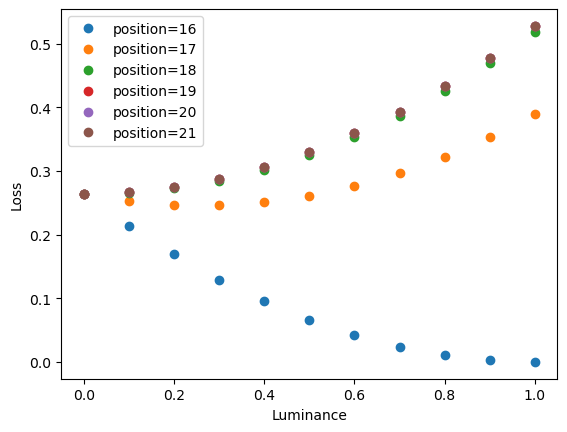

In [8]:
for position in range(16, 22, 1):
    loss_set = []
    for lum in range(0, 11):
        predi = torch.zeros([32, 32, 32])
        predi[position, 16, 16] = lum / 10
        loss_set.append(mse_loss(predi, label, 7, 0.5))
    plt.plot(
        torch.linspace(0, 10, 11)/10, loss_set, 'o', 
        label="position={}".format(position))
plt.xlabel('Luminance')
plt.ylabel('Loss')
plt.legend()
plt.show()